In [76]:
from qiskit import QuantumCircuit
from qiskit import quantum_info

In [89]:
n = 10
qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i)

In [90]:
sv = quantum_info.Statevector(qc)
sv.draw('latex')

<IPython.core.display.Latex object>

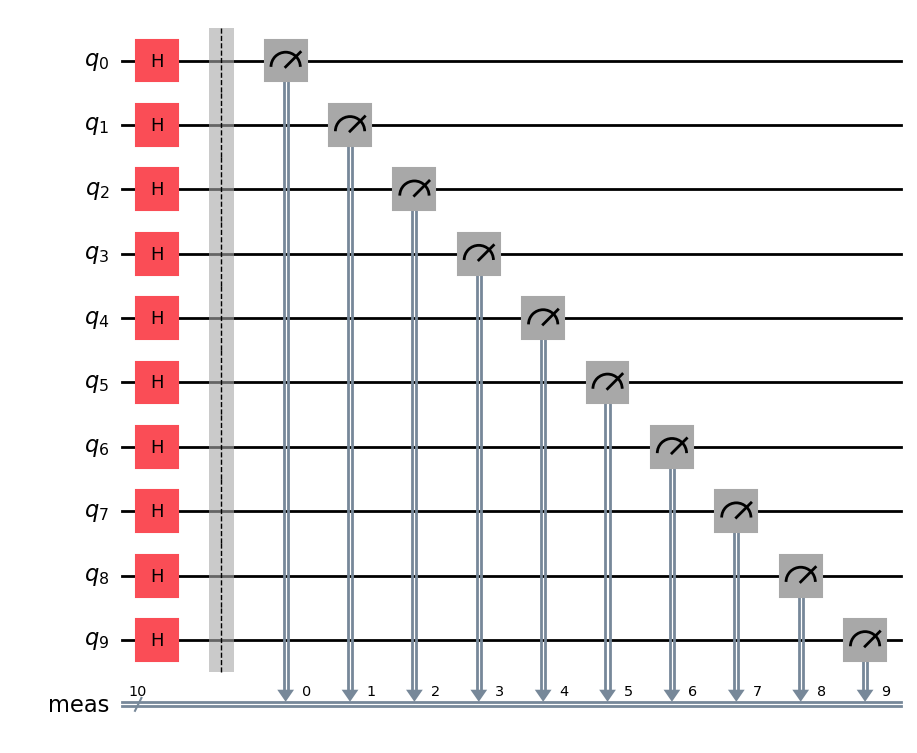

In [92]:
qc.measure_all()
qc.draw('mpl')

In [80]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel = "ibm_quantum", # ibm_cloud
                               token = "444eec52519bcaafe4eb447aaad3d0aacb35e281d21caaacff75db8fafab05d8786a9adb51627c85085a6ab22cb44b683d11a8cede0e1b695a26b2cfb7d1d786")
backend = service.least_busy(simulator=False, operational=True)

In [81]:
from qiskit import transpile

transpile_qc = transpile(qc, backend=backend, optimization_level=1)

In [82]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend)

job = sampler.run([(transpile_qc,None,1)])
job.result()

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-10-18 07:46:43', stop='2024-10-18 07:46:52', size=1>)])}, 'version': 2})

In [83]:
job.result()[0].data.meas.get_counts()

{'11': 1}

In [108]:
from qiskit_aer import AerSimulator

backend_aer = AerSimulator()

transpile_qc_aer = transpile(qc, backend=backend_aer, optimization_level=2)
sampler_aer = Sampler(backend_aer)

job_aer = sampler_aer.run([(transpile_qc_aer,None,1)])
I = job_aer.result()[0].data.meas.get_counts().keys()
n = int(list(I)[0], 2)
n

156